In [1]:
# Libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns

# PE2. Estudio de técnicas de visualización de datos

## Datos

In [2]:
def load_and_clean_household_gross_income_data(filepath: str) -> pd.DataFrame:
    """
    Load the household gross income distribution data and clean it.
    Source: https://www.ine.es/jaxiT3/Tabla.htm?t=31098&L=0
    """
    replacement_map = {
        'Fuente de ingreso: salario': 'Salarios',
        'Fuente de ingreso: pensiones': 'Pensiones',
        'Fuente de ingreso: prestaciones por desempleo': 'Prestaciones sociales',
        'Fuente de ingreso: otras prestaciones': 'Prestaciones sociales',
        'Fuente de ingreso: otros ingresos': 'Rendimientos del capital',
    }

    df = pd.read_csv(
        filepath,
        encoding='iso-8859-1',
        sep=';',
        decimal=',',
        usecols=[
            'Distribución por fuente de ingresos', 'Periodo', 'Total'
        ]
    )

    return (
        df
        .rename(columns={
            'Distribución por fuente de ingresos': 'Ingresos',
            'Periodo': 'Año',
            'Total': 'Porcentaje',
        })
        .replace({'Ingresos': replacement_map})
        .groupby(['Año', 'Ingresos'], as_index=False)['Porcentaje']
        .sum()
        .sort_values(['Año', 'Porcentaje'])
        # Normalize values to ensure each year total sum is 100 to avoid rounding errors
        .assign(
            Porcentaje=lambda d: d.groupby('Año')['Porcentaje'].transform(lambda x: 100 * x / x.sum())
        )
        .round(2)
    )


def load_and_clean_unemployment_data(filepath: str) -> pd.DataFrame:
    """
    Load unemployment data and return unemployment rates for districts.
    Source: https://servpub.madrid.es/CSEBD_WBINTER/seleccionSerie.html?numSerie=0904010000014
    """
    df = pd.read_csv(
        filepath,
        encoding='utf-8',
        sep=';',
        decimal=',',
        skiprows=8,
        skipfooter=4,
        engine='python',
        names=['Distrito', 'Barrio', 'Tasa de paro']
    )

    return (
        df
        .loc[lambda d: d['Distrito'] == d['Barrio'], ['Distrito', 'Tasa de paro']]
        .assign(CDIS=lambda d: d['Distrito'].str.slice(0, 2))
        .reset_index(drop=True)
        .loc[:, ['Distrito', 'CDIS', 'Tasa de paro']]
    )


def load_and_clean_household_net_income_data(filepath: str) -> pd.DataFrame:
    """
    Load the household net mean income data and clean it.
    Source: https://www.ine.es/jaxiT3/Tabla.htm?t=31097&L=0
    """
    df = pd.read_csv(
        filepath,
        encoding='iso-8859-1',
        sep=';',
        thousands='.',
        usecols=['Distritos', 'Periodo', 'Total']
    )

    return (
        df
        .rename(columns={
            'Periodo': 'Año',
            'Total': 'Renta neta media por hogar'
        })
        .assign(
            CDIS=lambda d: d['Distritos'].str.extract(r'(\d{2})$')[0],
            # Format income as a currency
            Renta_EUR=lambda d: d['Renta neta media por hogar'].map(lambda x: f'{x:,}'.replace(',', '.') + ' €')
        )
        .loc[:, [
            'Distritos', 'CDIS', 'Año', 'Renta neta media por hogar', 'Renta_EUR'
        ]]
    )


def load_madrid_districts(filepath: str) -> gpd.GeoDataFrame:
    """
    Load the geographical data representing the districts of Madrid from the
    specified shapefile location.
    Source. https://geoportal.madrid.es/IDEAM_WBGEOPORTAL/dataset.iam?id=541f4ef6-762b-11e9-861d-ecb1d753f6e8
    """
    gdf = gpd.read_file(filepath)

    return (
        gdf
        .loc[:, ['COD_DIS_TX', 'NOMBRE', 'geometry']]
        .rename(columns={
            'COD_DIS_TX': 'CDIS',
            'NOMBRE': 'Distrito'
        })
        .assign(
            Distrito=lambda d: d['Distrito'].str.replace(' - ', '-')
        )
    )


def merge_data(
        df_unemployment: pd.DataFrame, df_income: pd.DataFrame, gdf_districts: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Merge the unemployment, household income and districts DataFrames on the 'CDIS' column.
    Add centroid coordinates for hexbin plotting.
    """
    merged = (
        gdf_districts
        .merge(
            pd.merge(
                df_unemployment,
                df_income,
                on='CDIS'
            ),
            on='CDIS',
            suffixes=('_gdf', '_df')
        )
        .rename(columns={'Distrito_gdf': 'Distrito'})
        .loc[:, [
            'Distrito', 'CDIS', 'Año', 'Renta neta media por hogar', 'Renta_EUR', 'Tasa de paro', 'geometry'
        ]]
    )

    # Transform GeoDataFrame to EPSG:4326
    merged_wgs84 = merged.to_crs(epsg=4326)
    # Calculate representative points
    merged_wgs84['points'] = merged_wgs84.geometry.representative_point()
    # Extract latitude/longitude
    merged_wgs84['lat'] = merged_wgs84['points'].y
    merged_wgs84['lon'] = merged_wgs84['points'].x
    merged_wgs84 = merged_wgs84.drop(columns='points')

    return merged_wgs84

filepath_distribution = 'Data/Distribución renta por fuente de ingresos.csv'
filepath_unemployment = 'Data/Tasa de paro.csv'
filepath_income = 'Data/Renta neta media por hogar.csv'
filepath_districts = 'Distritos/DISTRITOS.shp'

df_distribution = load_and_clean_household_gross_income_data(filepath_distribution)
df_unemployment = load_and_clean_unemployment_data(filepath_unemployment)
df_income = load_and_clean_household_net_income_data(filepath_income)
gdf_districts = load_madrid_districts(filepath_districts)
merged_data = merge_data(df_unemployment, df_income, gdf_districts)

## Gráfico de área

In [3]:
def create_income_area_chart(df: pd.DataFrame) -> go.Figure:
    """
    Create a stacked area chart of the household income distribution over time.
    """
    fig = px.area(
        df,
        x='Año',
        y='Porcentaje',
        color='Ingresos',
        color_discrete_sequence=px.colors.qualitative.D3,
        labels={
            'Año': 'Año',
            'Porcentaje': '% del total de ingresos',
            'Ingresos': 'Fuente de ingresos',
        },
        width=1100,
        height=500
    )

    fig.update_layout(
        template='ggplot2',
        plot_bgcolor='white',
        hovermode='x',
        yaxis=dict(ticksuffix='%'),
        separators=', ',
        legend=dict(title='Fuente de ingresos', traceorder="reversed"),
        margin=dict(t=30, b=0, l=0, r=0),
        title=dict(
            text='Distribución de la renta bruta de los hogares en el municipio de Madrid (2015-2023)',
            font=dict(size=16),
            x=0.425,
            xanchor='center'
        )
    )

    fig.update_layout(
        xaxis_title=None
    )

    # Show 2 decimals on the hover
    fig.update_traces(
        hovertemplate='%{y:.2f}%'
    )

    return fig

fig = create_income_area_chart(df_distribution)
fig.show()
fig.write_html("plot1.html")

## Matriz de correlación

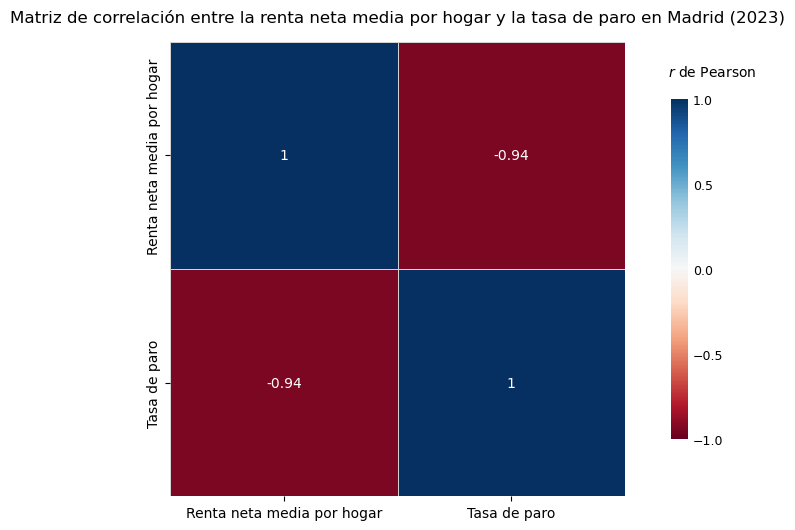

In [4]:
def plot_correlation_matrix(
        df: pd.DataFrame | gpd.GeoDataFrame, svg_path: str | None = None
) -> None:
    # Compute Pearson correlation matrix
    corr_matrix = (
        df[['Renta neta media por hogar', 'Tasa de paro']]
        .corr()
        .round(2)
    )

    plt.figure(figsize=(9.5, 5.4))

    # Plot a heatmap
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='RdBu',
        center=0,
        square=True,
        linecolor='lightgrey',
        linewidths=0.4,
        vmin=-1,
        vmax=1,
        cbar_kws={'shrink': 0.75}
    )

    # Get the colorbar
    cbar = ax.collections[0].colorbar
    # Create the colorbar label
    cbar.set_label('$r$ de Pearson', rotation=0)
    # Adjust the colorbar label position (x = horizontal; y = vertical)
    cbar.ax.yaxis.set_label_coords(2.45, 1.1)
    # Hide tick lines
    cbar.ax.tick_params(length=0)
    # Define tick values
    cbar.set_ticks([1, 0.5, 0, -0.5, -1])
    # Set tick text size
    cbar.ax.yaxis.set_tick_params(labelsize=9) 

    plt.title(
        'Matriz de correlación entre la renta neta media por hogar y la tasa de paro en Madrid (2023)',
        fontsize=12,
        loc='center',
        y=1.025
    )

    plt.xticks(rotation=0)
    plt.yticks(rotation=90)
    plt.tight_layout()
    
    if svg_path:
        plt.savefig(svg_path, format='svg')
    
    plt.show()

correlation_plot = plot_correlation_matrix(merged_data, svg_path='plot2.svg')
correlation_plot

## Agrupamiento hexagonal (*haxagonal binning*)

In [5]:
# Since Plotly v5.24, Mapbox has been replaced by MapLibre.
# https://plotly.com/python/hexbin-mapbox/
# https://plotly.com/python/mapbox-to-maplibre/

import json

def plot_hexbin(df: pd.DataFrame | gpd.GeoDataFrame) -> go.Figure:
    # Convert your GeoPandas dataframe's geometry to GeoJSON
    geojson_polygons = json.loads(df.geometry.to_json())
    
    fig = ff.create_hexbin_map(
        data_frame=df,
        lat='lat',
        lon='lon',
        nx_hexagon=4,
        opacity=0.8,
        map_style='carto-positron', 
        zoom=9.9,
        color_continuous_scale="Inferno",
        color='Renta neta media por hogar',
        labels={'color': 'Renta neta media por hogar'},
        show_original_data=True,
        original_data_marker=dict(size=7, color='lightblue', opacity=0.95),
        height=600
    )

    # Format label values with dot as thousands separator
    def format_thousands_dot(x):
        return f"{x:,}".replace(",", ".") + " €"
    
    tickvals = list(range(30000, 70001, 5000))
    ticktext = [format_thousands_dot(value) for value in tickvals]

    # Disable hover on hexbin aggregation
    fig.data[0].update(hoverinfo='skip', hovertemplate=None)

    # Customize hover on original data points
    fig.data[1].update(
        hovertemplate=(
            "Distrito: %{customdata[0]}<br>" +
            "Renta media: %{customdata[1]}"
        ),
        customdata=df[['Distrito', 'Renta_EUR']].values
    )

    fig.update_layout(      
        coloraxis_colorbar=dict(
            tickvals=tickvals,
            ticktext=ticktext
        ),
        margin=dict(t=30, b=0, l=0, r=0),
        title=dict(
            text="Renta neta media por hogar en los distritos de Madrid (2023)",
            font=dict(size=16),
            xanchor='center',
            x=0.4
        ),
    )

    return fig

fig = plot_hexbin(merged_data)
fig.show()
fig.write_html("plot3.html")